# Creación de un agente para la detección de caidas
## Introducción

Los seres humanos tenemos un proceso de deterioro natural de nuestro cuerpo. Esto ocasiona que muchos de nosotros cuando llegamos a una edad avanzada, aproximadamente de 60 años en adelante, necesitemos asistencia especial para suplir problemas de salud. Varios de los problemas más comunes de salud debido al proceso de envejecimiento están relacionados con la motricidad.  Algunas personas empiezan a tener problemas para movilizarse y pueden perder el equilibrio fácilmente aumentando la probabilidad de sufrir una caída.

Para las familias que tiene algún miembro con estas dificultades y que no pueden permitirse contratar personal especializado que cuiden de este, es muy importante, al menos, saber si el adulto mayor ha tenido una caída para así auxiliarlo a tiempo. 
Actualmente se pueden comprar en el mercado dispositivos electrónicos que en general constan de un sensor que debe portar el paciente y una app que se instala en el móvil. El sensor al detectar una caída se comunica con la app y esta le da un tiempo al usuario para abortar el proceso de aviso. Si el usuario no aborta, la app envía mensajes avisando de la caída e información de la ubicación GPS a los familiares.

En este proyecto implementamos un sistema que da información oportuna a familiares de personas propensas a caídas, para así hacer una diferencia significativa en el tiempo que tardan en ser atendidos en caso de sufrir una caída. Este sistema es gratuito y se plantea la posibilidad de que se pueda descargar, modificar e implementar por cualquier persona que lo necesite.


## Materiales y métodos
En general, el sistema consiste en leer los datos del acelerómetro que tiene el móvil del usuario para ser transmitidos en tiempo real a un pc. En este pc receptor esta implementado un agente inteligente, que una vez recepciona estos datos, él toma segmentos de a 5 segundos de información y usa un modelo de redes neuronales de tipo Long Short Term Memory, para clasificar entre una caída y una no caída. En caso de que detecte una caída, envía un mensaje a un correo electrónico prestablecido.


## Construcción de una base de datos inicial 
Para que el sistema tuviera mayor probabilidad de funcionar bien en diferentes móviles, la recolección de los datos necesaria para entrenar el sistema de aprendizaje de maquina se realizó a través de cuatro móviles del sistema operativo Android pero de diferentes marcas y características. Para cada móvil se realizó el siguiente procedimiento.

Con la app IMU+GPS Stream de PlayStore, usando el protocolo UDP, se trasmitieron los datos del acelerómetro a una computadora. En dicha computadora se implementó el notebook imu_stream.ipynb el cual permite guardar y etiquetar la información del acelerómetro. Los datos se guardaron en el formato CSV, un formato muy común en el análisis de datos. Un solo archivo CSV representa una serie de tiempo de aproximadamente 5 segundos, el cual es etiquetado como caida o no caida. Cada línea del archivo corresponde a un conjunto de datos tomados al mismo tiempo, el cual contiene: (Unnamed: 0) el número del dato, (time) el tiempo de grabación, y (acc1, acc2, acc3) los tres valores que grabó del acelerómetro del celular. A continuación se muestra el formato de los datos.

En total, tomamos datos de 100 caídas y 100 no caídas (cada archivo csv tiene información de una caida o no caida). El notebook imu_stream.ipynb crea un archivo adicional para guardar cuáles de los archivos CSV representan caídas y cuáles no. 

La toma de datos de no caídas se realizó mientras se hacían actividades cotidianas de un adulto mayor.  Como lo son, sentarse, parce, acostarse, levantarse, subir escaleras, bajar escaleras caminar y estar inmóvil. Por otra parte para la toma de datos de caída, se simularon caídas sobre un colchón y sobre el pasto. Las caídas fueron de lado derecho, lado izquierdo, hacia delante hacia atrás y de frente. 

## Modelo

Construimos un modelo llamado "Long Short-Term Memory" (LSTM), lo cual es diseñado para poder cambiar la valoración de las aristas de una red neuronal significantemente y no dependiendo del tiempo de entrenamiento que ya ha pasado.
El modelo cuenta con 255 nodos de entrada, representando todos los datos individuales grabados, 30 nodos en la segunda etapa, 15 en la tercera y dos al final. Interpretamos los últimos dos nodos como (1) caída y (2) no caída.
Entrenamos el modelo usando librerías públicas de Python, lo cual nos permitió quedarnos a cierta distancia del funcionamiento adentro de las "caja negra"

# Implementacion del modelo

##  Entrenamiento de las redes neuronales

Pasamos a la parte en la que usamos los datos para ajustar un modelo que clasifique las series de tiempo. Primero necesitamos separar los datos en train y test. 

### Separación del dataset en train y test

El análisis de datos resulta más fácil si todos los archivos son del mismo tamaño. Por esta razón como primer paso llenamos los archivos más cortos con el valor 0 hasta que todos estuvieran del mismo tamaño. Separamos el conjunto de archivos en tres: Un conjunto de datos para el entrenamiento, otro conjunto para la validación, y un tercer conjunto para los tests.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir

In [5]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint


Using TensorFlow backend.
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) o

Mostremos algunos datos 

In [285]:
target = pd.read_csv('./data/target.csv')
targets = target.values[:,1]

In [7]:
path = './data/'
sequences = list()
for i in target['ID'].values:
    file_path = path + str(i) 
    print(file_path)
    df = pd.read_csv(file_path,index_col =0)
    df['acc1']= df['acc1'].astype('float')
    df['acc2']= df['acc2'].astype('float')
    df['acc3']= df['acc3'].astype('float')
    values = df.values
    sequences.append(values)

./data/dataset_gabriel_1.csv
./data/dataset_gabriel_2.csv
./data/dataset_gabriel_3.csv
./data/dataset_gabriel_4.csv
./data/dataset_gabriel_5.csv
./data/dataset_gabriel_6.csv
./data/dataset_gabriel_7.csv
./data/dataset_gabriel_8.csv
./data/dataset_gabriel_9.csv
./data/dataset_gabriel_10.csv
./data/dataset_gabriel_11.csv
./data/dataset_gabriel_12.csv
./data/dataset_gabriel_13.csv
./data/dataset_gabriel_14.csv
./data/dataset_gabriel_15.csv
./data/dataset_gabriel_16.csv
./data/dataset_gabriel_17.csv
./data/dataset_gabriel_18.csv
./data/dataset_gabriel_19.csv
./data/dataset_gabriel_20.csv
./data/dataset_gabriel_21.csv
./data/dataset_gabriel_22.csv
./data/dataset_gabriel_23.csv
./data/dataset_gabriel_24.csv
./data/dataset_gabriel_25.csv
./data/dataset_gabriel_26.csv
./data/dataset_gabriel_27.csv
./data/dataset_gabriel_28.csv
./data/dataset_gabriel_29.csv
./data/dataset_gabriel_30.csv
./data/dataset_gabriel_31.csv
./data/dataset_gabriel_32.csv
./data/dataset_gabriel_33.csv
./data/dataset_gabr

In [235]:
len(sequences)

198

In [13]:
len_sequences = []
for one_seq in sequences:
    len_sequences.append(len(one_seq))
pd.Series(len_sequences).describe()

count    198.000000
mean     114.611111
std       77.224541
min        2.000000
25%       70.000000
50%       74.500000
75%       80.500000
max      256.000000
dtype: float64

Aplicamos padding y truncamiento segun corresponda 

In [16]:
#Padding the sequence with the values in last row to max length
to_pad = 256
new_seq = []
for one_seq in sequences:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(4, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

#truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = 255
final_seq=sequence.pad_sequences(final_seq, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [139]:
final_seq.shape

(198, 255, 4)

# Data Augmentation
Para tener mas datos y aunmentar la precisión del modelo se utilizaron varias tecnicas de Data augmentation en series de tiempo. Para esto nos basamos en algunas tecnicas presentadas en este [repositorio](https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data).

In [214]:
def apply_augmentation(data,func):
    #print(data.shape)
    mod_data = []
    #print(mod_data.shape)
    for row in data:
        #print(row[0],np.hstack((row[:,:1], func(row[:,1:])))[0])
        mod_data.append(np.hstack((row[:,:1], func(row[:,1:]))))
    return np.array(mod_data)

data = final_seq[5,:,1:]
maxV = int(data.max())+1
minV = int(data.min())-1

def plot_differences(data,func,axis=[0,data.shape[0]-210,minV,maxV]):
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(2,5,1)
    ax.plot(data)
    ax.axis(axis)

    ax = fig.add_subplot(2,5,2)
    ax.plot(func(data))
    ax.axis(axis)

## Jittering
Change the data incluiding somo random noise.

In [186]:
def DA_Jitter(X, sigma=0.5):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

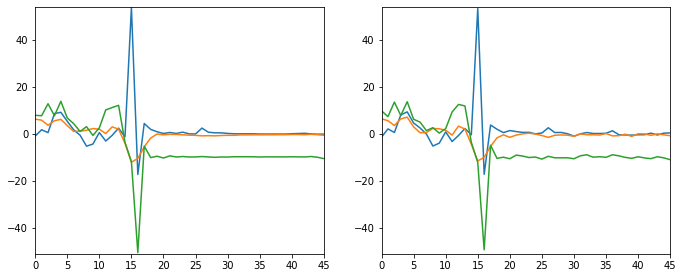

In [187]:
plot_differences(data, DA_Jitter)

In [188]:
aug_final_seq = np.append(final_seq,apply_augmentation(final_seq,DA_Jitter),axis=0)
final_targets = np.append(targets,targets,axis=0)

## Scaling

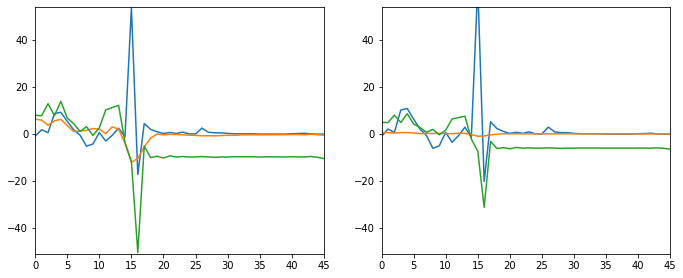

In [189]:
def DA_Scaling(X, sigma=0.4):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise
plot_differences(data,DA_Scaling)

In [190]:
aug_final_seq = np.append(aug_final_seq,apply_augmentation(aug_final_seq,DA_Scaling),axis=0)
final_targets = np.append(final_targets,final_targets,axis=0)

## Magnitude warping

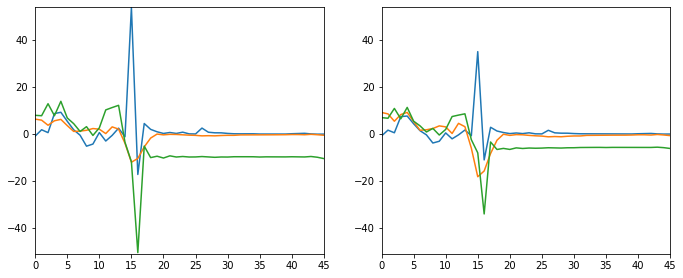

In [191]:
from scipy.interpolate import CubicSpline 

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DA_MagWarp(X, sigma=0.3):
    return X * GenerateRandomCurves(X, sigma)

plot_differences(data,DA_MagWarp)

In [192]:
aug_final_seq = np.append(aug_final_seq,apply_augmentation(aug_final_seq,DA_MagWarp),axis=0)
final_targets = np.append(final_targets,final_targets,axis=0)

## Time warping

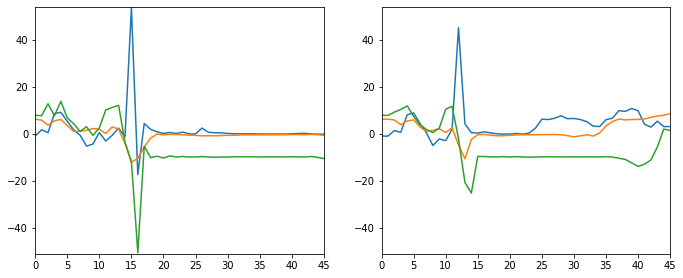

In [193]:
def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def DA_TimeWarp(X, sigma=0.4):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

plot_differences(data,DA_TimeWarp)

In [ ]:
aug_final_seq = np.append(aug_final_seq,apply_augmentation(aug_final_seq,DA_MagWarp),axis=0)
final_targets = np.append(final_targets,final_targets,axis=0)

In [ ]:
aug_final_seq.shape

In [ ]:
## Permutation

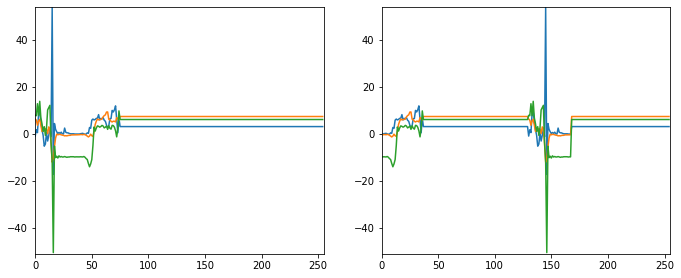

In [225]:
def DA_Permutation(X, nPerm=5, minSegLength=35):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return X_new

plot_differences(data,DA_Permutation,axis=[0,data.shape[0],minV,maxV])

In [223]:
aug_final_seq = np.append(aug_final_seq,apply_augmentation(aug_final_seq,DA_Permutation),axis=0)
final_targets = np.append(final_targets,final_targets,axis=0)

In [226]:
print(final_seq.shape)
aug_final_seq.shape

(198, 255, 4)


(12672, 255, 4)

# Construccion de train, validation y test
Tenemos que separar los datos en estos 3 conjuntos de datos para probar nuestro modelo de una manera adecuada


In [286]:
total = np.array([i for i in range(final_seq.shape[0])])
msk = np.random.rand(final_seq.shape[0]) < 0.7
train = total[msk]
msk2 = np.random.rand(total[~msk].shape[0]) < 0.5
test = total[~msk][msk2]
validation = total[~msk][~msk2]


train_target = target.iloc[train]['class_label'].values
test_target = target.iloc[test]['class_label'].values
validation_target = target.iloc[validation]['class_label'].values
train_target = (train_target+1)/2
validation_target = (validation_target+1)/2
test_target = (test_target+1)/2


train = final_seq[train,:,:]
test = final_seq[test,:,:]
validation = final_seq[validation,:,:]

In [287]:
print (train.shape, validation.shape, test.shape)

(125, 255, 4) (37, 255, 4) (36, 255, 4)


In [19]:
model = Sequential()
model.add(LSTM(30, input_shape=(seq_len, 4), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(15, return_sequences=True))
model.add(Dropout(0.2))
#model.add(LSTM(30, return_sequences= True))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='relu'))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 255, 30)           4200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 255, 30)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 255, 15)           2760      
_________________________________________________________________
dropout_3 (Dropout)          (None, 255, 15)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3825)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3826      
Total params: 10,786
Trainable params: 10,786
Non-trainable params: 0
_________________________________________________________________


In [21]:
adam = Adam(lr=0.0001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=60, batch_size=4, callbacks=[chk], validation_data=(validation,validation_target))

W0922 23:12:13.593125 140488869955392 deprecation_wrapper.py:119] From /home/gabriel/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0922 23:12:13.599617 140488869955392 deprecation_wrapper.py:119] From /home/gabriel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0922 23:12:13.604444 140488869955392 deprecation.py:323] From /home/gabriel/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 143 samples, validate on 24 samples
Epoch 1/60
143/143 [==============================] - 9s 64ms/step - loss: 3.8095 - acc: 0.4825 - val_loss: 5.1712 - val_acc: 0.3750
Epoch 2/60
143/143 [==============================] - 8s 55ms/step - loss: 2.8041 - acc: 0.5245 - val_loss: 4.7224 - val_acc: 0.4167
Epoch 3/60
143/143 [==============================] - 8s 55ms/step - loss: 2.1415 - acc: 0.5874 - val_loss: 2.8911 - val_acc: 0.4167
Epoch 4/60
143/143 [==============================] - 8s 55ms/step - loss: 1.8148 - acc: 0.5944 - val_loss: 2.7614 - val_acc: 0.4583
Epoch 5/60
143/143 [==============================] - 8s 55ms/step - loss: 1.5336 - acc: 0.6084 - val_loss: 2.0633 - val_acc: 0.5833
Epoch 6/60
143/143 [==============================] - 9s 61ms/step - loss: 0.9833 - acc: 0.6294 - val_loss: 1.4639 - val_acc: 0.5833
Epoch 7/60
143/143 [==============================] - 9s 62ms/step - loss: 0.8763 - acc: 0.6014 - val_loss: 0.7919 - val_acc: 0.5833
Epoch 8/60
143/143 [====

# ¿Como se comporta en datos que no ha visto?

In [288]:
model = load_model('best_model.pkl')

from sklearn.metrics import f1_score
test_preds = model.predict_classes(test)
f1_score(test_target, test_preds)

0.8648648648648649

#  Preparando preprocessing y envío del e-mail

Ahora que queremos el modelo funcionando en todo momento, tenemos que automatizar estas tareas.

In [307]:
#Padding the sequence with the values in last row to max length
def padding(s):
    to_pad = 256
    new_seq = []
    for one_seq in s:
        len_one_seq = len(one_seq)
        last_val = one_seq[-1]
        n = to_pad - len_one_seq

        to_concat = np.repeat(one_seq[-1], n).reshape(4, n).transpose()
        new_one_seq = np.concatenate([one_seq, to_concat])
        new_seq.append(new_one_seq)
    f = np.stack(new_seq)

    #truncate the sequence to length 60
    from keras.preprocessing import sequence
    seq_len = 255
    return sequence.pad_sequences(f, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [298]:
 
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import smtplib

def send_email(message = "Contacta a tu usuario, se callo"):
    # create message object instance
    msg = MIMEMultipart()

    # setup the parameters of the message
    password = "Gjnc2019"
    msg['From'] = "caidasartificiales@gmail.com"
    msg['To'] = "gabriel.octavius@gmail.com"
    msg['Subject'] = "Urgente caida"

    # add in the message body
    msg.attach(MIMEText(message, 'plain'))

    #create server
    server = smtplib.SMTP('smtp.gmail.com: 587')

    server.starttls()

    # Login Credentials for sending the mail
    server.login(msg['From'], password)

    # send the message via the server.
    server.sendmail(msg['From'], msg['To'], msg.as_string())

    server.quit()

# Creación del agente 

In [245]:
import socket

path = './data/'
target = 'target.csv'
nuevo_nombre = 'dataset_gabriel_50.csv'
caida = False

### Averiguemos nuestra IP

In [302]:
def get_ip():
    s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    try:
        # doesn't even have to be reachable
        s.connect(('10.255.255.255', 1))
        IP = s.getsockname()[0]
    except:
        IP = '127.0.0.1'
    finally:
        s.close()
    return IP
print(get_ip())

192.168.1.103


In [ ]:
import socket
s=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
s.bind(('',5558))

time, acc1, acc2, acc3 =[],[],[],[]
time_taken=False
time0=0
i = 0

while True:
    data,addr=s.recvfrom(5558)
    procesado = str(data).split('\'')[1].split(',')
    if not time_taken:
        time0 = procesado[0] 
        time_taken= True
    time.append( - float(time0)+float(procesado[0]))
    acc1.append(float(procesado[2]))
    acc2.append(float(procesado[3]))
    acc3.append(float(procesado[4]))
    i+=1
    if i%50 == 0:
        if i>255:
            time = time[-255:]
            acc1 = acc1[-255:]
            acc2 = acc2[-255:]
            acc3 = acc3[-255:]
            time0 = procesado[0]
        vals = pd.DataFrame({'time': time, 'acc1': acc1,'acc2':acc2,'acc3':acc3}).values
        print("Predict: ", model.predict_classes(padding([vals])))
        if model.predict_classes(padding([vals]))[0,0]>0:
            print("Se cayo")
            #send_email()
        else:
            print("Todo bien")
        

tiempo Transcurrido = 2.455440000005183
Predict:  [[0]]
tiempo Transcurrido = 4.43528000000515
Predict:  [[0]]
tiempo Transcurrido = 6.415049999995972
Predict:  [[0]]
tiempo Transcurrido = 8.553260000000591
Predict:  [[0]]
tiempo Transcurrido = 10.53306000000157
Predict:  [[0]]
tiempo Transcurrido = 12.512879999994766
Predict:  [[1]]
Se cayo
tiempo Transcurrido = 1.9798200000077486
Predict:  [[1]]
Se cayo
tiempo Transcurrido = 1.9798000000009779
Predict:  [[1]]
Se cayo
tiempo Transcurrido = 2.019349999987753
Predict:  [[1]]
Se cayo
tiempo Transcurrido = 1.9798000000009779
Predict:  [[1]]
Se cayo
tiempo Transcurrido = 1.9798200000077486
Predict:  [[0]]
tiempo Transcurrido = 1.9797899999975925
Predict:  [[0]]
tiempo Transcurrido = 1.9798000000009779
Predict:  [[0]]
tiempo Transcurrido = 1.9797899999975925
Predict:  [[0]]
tiempo Transcurrido = 1.979829999996582
Predict:  [[0]]
tiempo Transcurrido = 1.979830000011134
Predict:  [[0]]
tiempo Transcurrido = 2.019369999994524
Predict:  [[0]]
t